# Notebook Summary
1. https://machinelearningmastery.com/autoencoder-for-classification/
2. https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/
3. https://www.tensorflow.org/tutorials/generative/autoencoder


In [1]:
import numpy as np
import os
import pandas as pd
import re
import gc 
import random
import os
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

In [2]:
def df_to_np(df): #convert df to np array, seperate labels and attack
    X = df.iloc[:,0:-2].to_numpy()
    y = df.iloc[:,-2:].to_numpy()
    return X, y
    
def seperate_label_attack(y):
    a = y[:,0]
    y = np.asarray(y[:,1]).astype('int8')
    return y, a

def split_train_val(df, val_ratio):
    df_val = df[df['Attack']=='Benign'].sample(frac=(val_ratio/2))
    df_val = pd.concat([df_val, df[df['Attack']!='Benign'].sample(frac=(val_ratio/2))], axis=0)
    df.drop(df_val.index, inplace=True)
    #df.reset_index(drop=True, inplace=True)
    #df_val.reset_index(drop=True, inplace=True)
    return df_val, df

def bgta_ub(df, r, p): #benign count gt anomaly count distribution for BoT-IoT
    df_tr = df[df['Label']==1]
    if p == 1:
        total_benign = int(round(len(df_tr.index)/(1-r))*(r))
    else:
        total_benign = int(round(((len(df_tr.index)/(1-r))*(r)*p)))
    df_tr = pd.concat([df_tr, df[df['Label'] == 0].sample(n=total_benign)], axis=0)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def agtb_ub(df, attacks, r, p): #benign count gt anomaly count
    tot_dist = df['Label'].value_counts()
    df_tr = df[df['Label']==0]
    total_anomaly = int(round(len(df_tr.index)/r)*(1-r))
    f = total_anomaly/(tot_dist[1])
    for attack in attacks:
        if attack == 'DDoS':
            df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=f)], axis=0)
        else:
            df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=f)], axis=0)
    if p < 1:
        df_tr.drop((df_tr[df_tr['Label']==0].sample(frac=(1-p))).index, inplace=True)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def balance_dataset(df): #balance all attack categories for training
    attacks = df[df['Attack'] != 'Benign']['Attack'].unique()
    value_c = df[df['Attack'] != 'Benign']['Attack'].value_counts()
    tot_dist = df['Label'].value_counts()
    print('Splitting Datasets')
    if tot_dist[0] > tot_dist[1]:
        df, df_tr = bgta(df, attacks, value_c)
    else:
        df, df_tr = agtb(df, attacks, value_c)
    return df, df_tr

def unbalance_train(df, r, p, max_borrowed_samples):
    attacks = df[df['Attack'] != 'Benign']['Attack'].unique()
    value_c = df[df['Attack'] != 'Benign']['Attack'].value_counts()
    tot_dist = df['Label'].value_counts()
    if p > 0:
        if tot_dist[0] > tot_dist[1]:
            df, df_tr = bgta_ub(df, r, p)
        else:
            df, df_tr = agtb_ub(df, attacks, r, p)
    if p == 0:
        df_tr = pd.DataFrame()
        for attack in attacks:
            try:
                df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(n=round((max_borrowed_samples*((1-r)/r)*0.33)/len(attacks)))], axis=0)
            except:
                df_tr = pd.concat([df_tr, df[df['Attack'] == attack]], axis=0)
        df.drop(df_tr.index, inplace=True)
    return df, df_tr

In [3]:
#isolate               0              1                              2                 3
files = ['CNF-BoT-IoT-v2.csv', 'CNF-CSE-CIC-IDS2018-v2.csv', 'CNF-ToN-IoT-v2b.csv', 'CNF-UNSW-NB15-v2.csv']
isolate = 1
r = 0.5 #benign to anomaly ratio
folder= 'rboa/' #folder to save dataset to
dir = '../../../Datasets/NF-UQ-NIS-2/' #original dataset directory
max_borrowed_samples = 5000000 #borrowed samples from testing data for training data, mixed/replaced benign scenario
oboa_dir = 'oboa/'

d = {#'L4_SRC_PORT': np.int32,
    'L4_DST_PORT': np.int32,
    'PROTOCOL': np.int32,
    'L7_PROTO': np.float64,
    'IN_BYTES': np.int32,
    'IN_PKTS': np.int32,
    'OUT_BYTES': np.int32,
    'OUT_PKTS': np.int32,
    'TCP_FLAGS': np.int32,
    'CLIENT_TCP_FLAGS': np.int32,
    'SERVER_TCP_FLAGS': np.int32,
    'FLOW_DURATION_MILLISECONDS': np.int32,
    'DURATION_IN': np.int32,
    'DURATION_OUT': np.int32,
    'MIN_TTL': np.int32,
    'MAX_TTL': np.int32,
    'LONGEST_FLOW_PKT': np.int32,
    'SHORTEST_FLOW_PKT': np.int32,
    'MIN_IP_PKT_LEN': np.int32,
    'MAX_IP_PKT_LEN': np.int32,
# 'SRC_TO_DST_SECOND_BYTES': np.float64,
# 'DST_TO_SRC_SECOND_BYTES': np.float64,
#  'RETRANSMITTED_IN_BYTES': np.int32,
#  'RETRANSMITTED_IN_PKTS': np.int32,
#  'RETRANSMITTED_OUT_BYTES': np.int32,
#  'RETRANSMITTED_OUT_PKTS': np.int32,
#  'SRC_TO_DST_AVG_THROUGHPUT': np.int32,
#  'DST_TO_SRC_AVG_THROUGHPUT': np.int32,
#  'NUM_PKTS_UP_TO_128_BYTES': np.int32,
#  'NUM_PKTS_128_TO_256_BYTES': np.int32,
#  'NUM_PKTS_256_TO_512_BYTES': np.int32,
#  'NUM_PKTS_512_TO_1024_BYTES': np.int32,
#  'NUM_PKTS_1024_TO_1514_BYTES': np.int32,
    'TCP_WIN_MAX_IN': np.int32,
    'TCP_WIN_MAX_OUT': np.int32,
    'ICMP_TYPE': np.int32,
    'ICMP_IPV4_TYPE': np.int32,
    'DNS_QUERY_ID': np.int32,
    'DNS_QUERY_TYPE': np.int32,
    'DNS_TTL_ANSWER': np.int32,
    'FTP_COMMAND_RET_CODE': np.int32
    }

headers = list(d.keys())
print('Selected # of features: {0}'.format(len(headers)))
headers.extend(('Attack', 'Label'))

print('Isolating: {0}'.format(files[isolate]))
isolated = files[isolate]
files.pop(isolate)
print(files)

Selected # of features: 27
Isolating: CNF-CSE-CIC-IDS2018-v2.csv
['CNF-BoT-IoT-v2.csv', 'CNF-ToN-IoT-v2b.csv', 'CNF-UNSW-NB15-v2.csv']


In [4]:
df = pd.read_csv(oboa_dir+'3_train.csv', dtype=d)
print('Training: Total Original Samples Before Dropping:', (len(df[df['Label']==0].index)))
tr_ben_samples = tr_ben_samples = len(df[df['Label']==0].index)
df.drop(df[df['Label']==0].sample(frac=1).index, inplace=True)
df.to_csv(folder+'3_train.csv', header=headers, index=None)

df = pd.read_csv(oboa_dir+'3_test.csv', dtype=d)
print('Test: Total Original Samples Before Dropping:', (len(df[df['Label']==0].index)))
test_ben_samples = len(df[df['Label']==0].index)
df.drop(df[df['Label']==0].sample(frac=1).index, inplace=True)
df.to_csv(folder+'3_test.csv', header=headers, index=None)

new_test_file = 'rb_r'+str(r)[2:]+'_'+isolated

print('Borrowing samples for replacement:',tr_ben_samples, test_ben_samples)
df = pd.read_csv(dir+isolated, usecols=['Label'])
df_1b_index_tr = df[df['Label']==0].sample(n=tr_ben_samples)
df.drop(df_1b_index_tr.index, inplace=True)
df_1b_index_test = df[df['Label']==0].sample(n=test_ben_samples)
df.drop(df_1b_index_test.index, inplace=True)
df_1b_index_tr = df_1b_index_tr.index.to_list()
df_1b_index_test = df_1b_index_test.index.to_list()
pd.DataFrame(columns=headers).to_csv(folder+new_test_file, header=headers, index=None)


for chunk in pd.read_csv(dir+isolated, usecols=headers, chunksize=10000000, iterator=True):
    train_data = pd.Index([n for n in df_1b_index_tr if n in range(chunk.index.start,chunk.index.stop)])
    test_data = pd.Index([n for n in df_1b_index_test if n in range(chunk.index.start,chunk.index.stop)])
    chunk.loc[train_data].to_csv(folder+'3_train.csv', mode = 'a', header=None, index=0)
    chunk.loc[test_data].to_csv(folder+'3_test.csv', mode = 'a', header=None, index=0)
    
    chunk.drop(index = train_data, inplace=True)
    chunk.drop(index = test_data, inplace=True)
    chunk.to_csv(folder+new_test_file, mode = 'a', header=None, index=0)
    print('done')

Training: Total Original Samples Before Dropping: 3834765
Test: Total Original Samples Before Dropping: 1278255
Borrowing samples for replacement: 3834765 1278255
done
done


3_train.csv

p: 0.5000000651930516


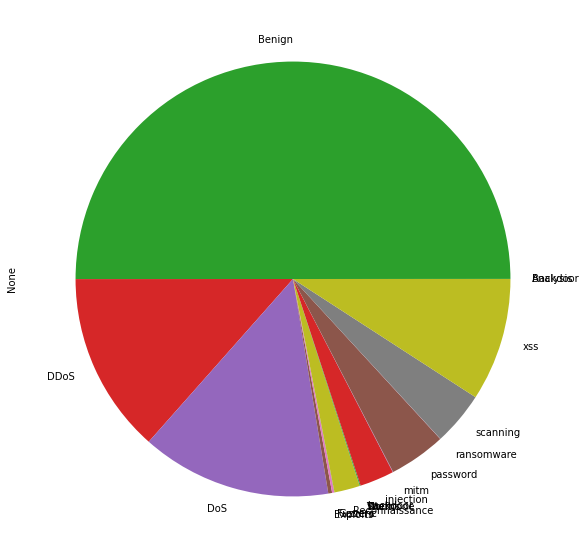

Attack
Analysis              297
Backdoor              257
Benign            3834765
DDoS              1031578
DoS               1084569
Exploits            21714
Fuzzers             11341
Generic              2246
Reconnaissance     145881
Shellcode             532
Theft                 118
Worms                 108
backdoor             4851
injection          196138
mitm                 2215
password           323834
ransomware            969
scanning           306599
xss                701517
dtype: int64

-------------------------------------
3_test.csv

p: 0.5


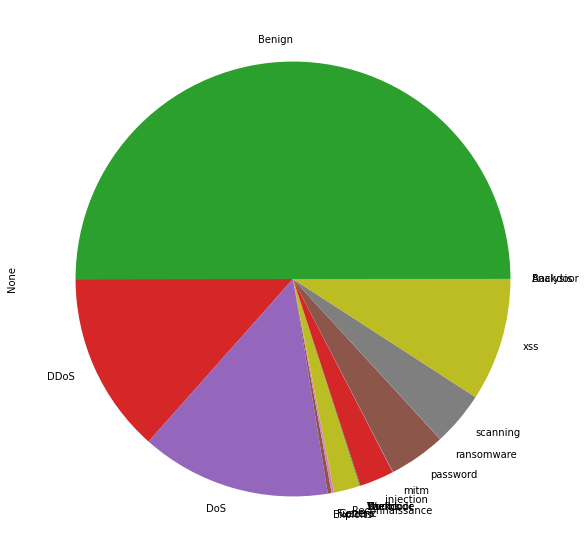

Attack
Analysis               83
Backdoor               84
Benign            1278255
DDoS               343503
DoS                360962
Exploits             7233
Fuzzers              3965
Generic               768
Reconnaissance      49023
Shellcode             179
Theft                  35
Worms                  35
backdoor             1598
injection           65549
mitm                  694
password           107763
ransomware            310
scanning           102688
xss                233783
dtype: int64

-------------------------------------


In [5]:
files = ['3_train.csv', '3_test.csv']
for file in files:
    print(file+'\n')
    df = pd.read_csv(folder+file, usecols=['Label','Attack'])
    print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
    count_series = df.groupby(['Attack']).size()
    count_series.plot(kind='pie', figsize=(10,10))
    plt.show()
    print(count_series)
    print('\n-------------------------------------')
    del df
    gc.collect()

In [6]:
print('Generating training data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_train.csv', dtype=d).sample(frac=1))
y, a = seperate_label_attack(y)
np.save(folder+'X_train.npy', X)
np.save(folder+'y_train.npy', y)

print('Generating test data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_test.csv', dtype=d).sample(frac=1))
y, a = seperate_label_attack(y)
np.save(folder+'X_test.npy', X)
np.save(folder+'y_test.npy', y)
        
del X
del y
del a
gc.collect()

Generating training data numpy arrays
Generating test data numpy arrays


0

Generating test 2 data numpy arrays
p: 0.8233854826224172


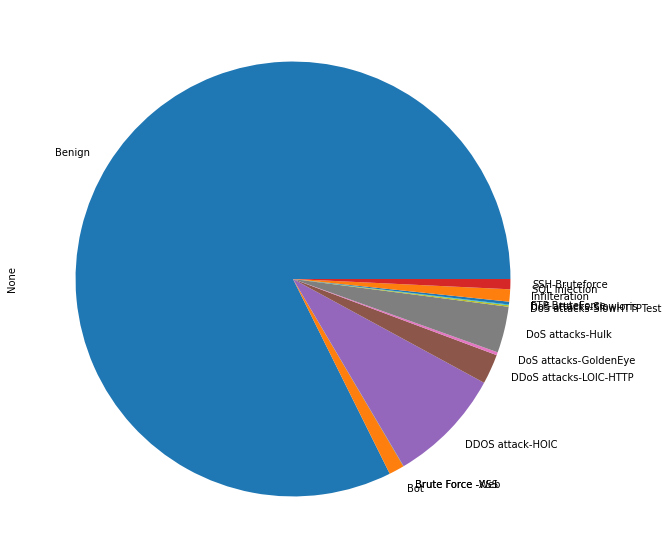

Attack
Benign                      10370746
Bot                           143097
Brute Force -Web                2094
Brute Force -XSS                 895
DDOS attack-HOIC             1080858
DDoS attacks-LOIC-HTTP        280337
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432487
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           7227
FTP-BruteForce                 25933
Infilteration                 114326
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64


In [9]:
print('Generating test 2 data numpy arrays')
new_test_file = 'rb_r5_CNF-CSE-CIC-IDS2018-v2.csv'

df = pd.read_csv(folder+new_test_file, usecols=['Label','Attack'])
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)
df = pd.read_csv(folder+new_test_file, dtype=d, usecols=headers)

X_1, y_1 = df_to_np(df)
y_1, a_1 = seperate_label_attack(y_1)

np.save(folder+'X_1.npy', X_1)
np.save(folder+'y_1.npy', y_1)
np.save(folder+'a_1.npy', a_1)

Generating test 2 data numpy arrays
p: 0.9350631388199289


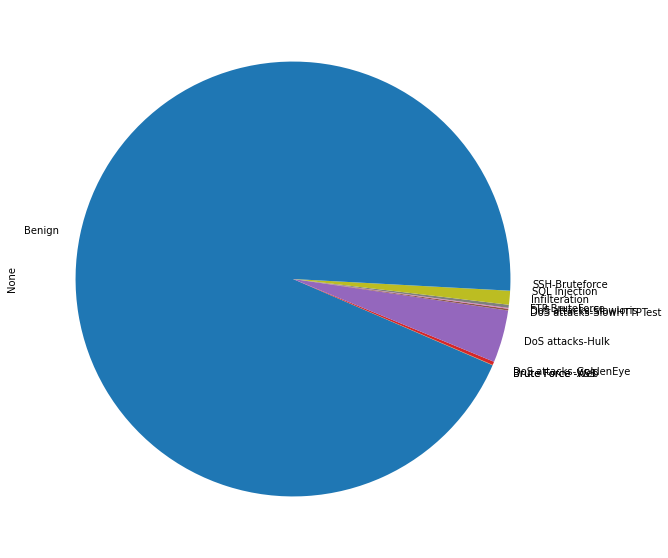

Attack
Benign                      10370746
Brute Force -Web                2094
Brute Force -XSS                 895
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432487
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           7227
FTP-BruteForce                 25933
Infilteration                 114326
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64


14571

In [11]:
print('Generating test 2 data numpy arrays')
df = pd.read_csv(folder+new_test_file, dtype=d, usecols=headers)
df.drop(df[df['Attack'] == 'DDOS attack-HOIC'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDoS attacks-LOIC-HTTP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDOS attack-LOIC-UDP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'Bot'].sample(frac=1).index, inplace=True)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)

X_1_ar, y_1_ar = df_to_np(df)
y_1_ar, a_1_ar = seperate_label_attack(y_1_ar)

np.save(folder+'X_1_ar.npy', X_1_ar)
np.save(folder+'y_1_ar.npy', y_1_ar)
np.save(folder+'a_1_ar.npy', a_1_ar)


del X_1_ar
del y_1_ar
del a_1_ar
del df
gc.collect()